In [5]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

In [6]:
import math
import torch


In [7]:
from torch.optim import Optimizer

Loading MNIST dataset...
Training samples: 8000
Test samples: 2000
Epoch 1/15 - Train acc: 91.34%, Test acc: 90.95%
Epoch 2/15 - Train acc: 93.51%, Test acc: 92.50%
Epoch 3/15 - Train acc: 94.75%, Test acc: 92.95%
Epoch 4/15 - Train acc: 95.49%, Test acc: 93.80%
Epoch 5/15 - Train acc: 96.60%, Test acc: 94.10%
Epoch 6/15 - Train acc: 97.42%, Test acc: 94.75%
Epoch 7/15 - Train acc: 98.00%, Test acc: 95.15%
Epoch 8/15 - Train acc: 98.42%, Test acc: 94.70%
Epoch 9/15 - Train acc: 98.56%, Test acc: 95.05%
Epoch 10/15 - Train acc: 98.99%, Test acc: 95.30%
Epoch 11/15 - Train acc: 99.04%, Test acc: 95.20%
Epoch 12/15 - Train acc: 99.08%, Test acc: 95.00%
Epoch 13/15 - Train acc: 99.56%, Test acc: 95.55%
Epoch 14/15 - Train acc: 99.67%, Test acc: 95.45%
Epoch 15/15 - Train acc: 99.65%, Test acc: 95.20%
Epoch 1/15 - Train acc: 91.34%, Test acc: 91.15%
Epoch 2/15 - Train acc: 93.61%, Test acc: 93.00%
Epoch 3/15 - Train acc: 94.80%, Test acc: 93.60%
Epoch 4/15 - Train acc: 95.39%, Test acc: 94.

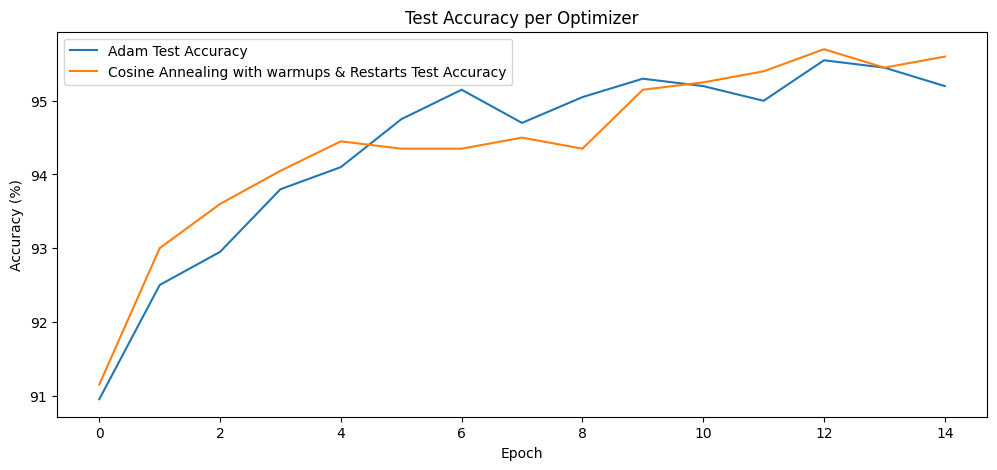

In [ ]:
"""
MNIST Neural Network Training with Custom Optimizers
Course: Optimization Methods
Assignment: Implement and Compare Custom Optimizers with Adam

This code demonstrates:
1. Loading MNIST dataset
2. Simple feedforward neural network architecture
3. Adam optimizer implementation as a class
4. Framework for students to implement their own optimizer
5. Training loop with accuracy and loss tracking
6. Visualization of results
"""



# ===================================================================
# PART 1: NEURAL NETWORK ARCHITECTURE
# ===================================================================

class SimpleNN:
    """
    Simple feedforward neural network with one hidden layer.
    Architecture: Input (784) -> Hidden (128) -> Output (10)
    """

    def __init__(self, input_size=784, hidden_size=128, output_size=10):
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((1, output_size))

        self.params = {'W1': self.W1, 'b1': self.b1,
                       'W2': self.W2, 'b2': self.b2}
        self.cache = {}

    def relu(self, Z):
        return np.maximum(0, Z)
    def relu_derivative(self, Z):
        return (Z > 0).astype(float)
    def softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)
    def forward(self, X):
        self.cache['X'] = X
        self.cache['Z1'] = X @ self.W1 + self.b1
        self.cache['A1'] = self.relu(self.cache['Z1'])
        self.cache['Z2'] = self.cache['A1'] @ self.W2 + self.b2
        self.cache['A2'] = self.softmax(self.cache['Z2'])
        return self.cache['A2']
    def backward(self, y_true):
        m = y_true.shape[0]
        dZ2 = self.cache['A2'] - y_true
        dW2 = (self.cache['A1'].T @ dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m
        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * self.relu_derivative(self.cache['Z1'])
        dW1 = (self.cache['X'].T @ dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m
        return {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2}
    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

# ===================================================================
# PART 2: OPTIMIZER BASE CLASS
# ===================================================================

class Optimizer:
    """
    Base class for optimizers.
    Students should inherit from this class to implement their own optimizer.
    """
    def __init__(self, learning_rate=0.001):
        self.learning_rate = learning_rate
        self.t = 0  # Time step

    def update(self, params, grads):
        raise NotImplementedError("Subclasses must implement update method")

# ===================================================================
# PART 3: ADAM OPTIMIZER IMPLEMENTATION
# ===================================================================

class Adam(Optimizer):
    """
    Adam optimizer (Adaptive Moment Estimation).
    Reference: Kingma & Ba (2015)
    """
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(learning_rate)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {} # First moment
        self.v = {} # Second moment

    def update(self, params, grads):
        if len(self.m) == 0:
            for key in params:
                self.m[key] = np.zeros_like(params[key])
                self.v[key] = np.zeros_like(params[key])
        self.t += 1
        for key in params:
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key]
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[key] ** 2)
            m_hat = self.m[key] / (1 - self.beta1 ** self.t)
            v_hat = self.v[key] / (1 - self.beta2 ** self.t)
            params[key] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

# ===================================================================
# PART 4: TEMPLATE FOR CUSTOM OPTIMIZER (FOR STUDENTS)
# ===================================================================


import numpy as np
import math

class AdamCosineWarmupRestarts:
    def __init__(
        self, 
        learning_rate=1e-3,
        beta1=0.9,
        beta2=0.999,
        epsilon=1e-8,
        warmup_steps=0,
        first_cycle_steps=1000,
        cycle_mult=1.0,
        max_lr=1e-3,
        min_lr=1e-5,
        gamma=1.0
    ):
        """
        Adam optimizer + Warmup + Cosine Annealing + Cosine Restarts (NumPy version)
        Works directly with SimpleNN.params & grads
        """
        self.base_lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        
        # scheduling
        self.warmup_steps = warmup_steps
        self.first_cycle_steps = first_cycle_steps
        self.cycle_mult = cycle_mult
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.gamma = gamma
        
        # state
        self.m = {}
        self.v = {}
        self.t = 0
        self.step_in_cycle = 0
        self.cur_cycle_steps = first_cycle_steps
        self.cycle = 0
        self.lr = self.min_lr

    def compute_lr(self):
        self.step_in_cycle += 1

        # ---- WARMUP ----
        if self.step_in_cycle <= self.warmup_steps:
            lr = self.min_lr + (self.max_lr - self.min_lr) * (
                self.step_in_cycle / self.warmup_steps
            )
        else:
            # ---- COSINE ANNEALING ----
            progress = (self.step_in_cycle - self.warmup_steps) / (
                self.cur_cycle_steps - self.warmup_steps
            )
            lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (
                1 + math.cos(math.pi * progress)
            )

        # ---- HANDLE RESTART ----
        if self.step_in_cycle >= self.cur_cycle_steps:
            self.cycle += 1
            self.step_in_cycle = 0
            self.cur_cycle_steps = int(self.cur_cycle_steps * self.cycle_mult)
            self.max_lr *= self.gamma

        self.lr = lr
        return lr

    def get_lr(self):
        return self.lr

    def update(self, params, grads):
        """Identical interface to your existing optimizer"""
        self.t += 1
        lr = self.compute_lr()

        # Initialize moment estimates lazily
        if len(self.m) == 0:
            for key in params:
                self.m[key] = np.zeros_like(params[key])
                self.v[key] = np.zeros_like(params[key])

        # Adam update (same as your code)
        for key in params:
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key]
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[key] ** 2)

            m_hat = self.m[key] / (1 - self.beta1 ** self.t)
            v_hat = self.v[key] / (1 - self.beta2 ** self.t)

            params[key] -= lr * m_hat / (np.sqrt(v_hat) + self.epsilon)


# ===================================================================
# PART 5: UTILITY FUNCTIONS
# ===================================================================

def load_mnist_data(subset_size=10000):
    try:
        from sklearn.datasets import fetch_openml
        from sklearn.model_selection import train_test_split

        print("Loading MNIST dataset...")
        mnist = fetch_openml('mnist_784', version=1, parser='auto', as_frame=False)
        X, y = mnist.data[:subset_size], mnist.target[:subset_size].astype(int)
        X = X.astype(np.float32) / 255.0
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        print(f"Training samples: {X_train.shape[0]}")
        print(f"Test samples: {X_test.shape[0]}")
        return X_train, X_test, y_train, y_test
    except Exception as e:
        print(f"Dataset load error: {e}")
        n_train, n_test = 8000, 2000
        X_train = np.random.rand(n_train, 784).astype(np.float32)
        X_test = np.random.rand(n_test, 784).astype(np.float32)
        y_train = np.random.randint(0, 10, n_train)
        y_test = np.random.randint(0, 10, n_test)
        return X_train, X_test, y_train, y_test

def one_hot_encode(y, num_classes=10):
    one_hot = np.zeros((y.shape[0], num_classes))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot

def compute_loss(predictions, y_true):
    predictions = np.clip(predictions, 1e-10, 1 - 1e-10)
    loss = -np.sum(y_true * np.log(predictions)) / y_true.shape[0]
    return loss

def compute_accuracy(predicted_labels, y_true):
    return np.mean(predicted_labels == y_true) * 100

def create_mini_batches(X, y, batch_size=32):
    m = X.shape[0]
    batches = []
    order = np.random.permutation(m)
    X_shuf = X[order]
    y_shuf = y[order]
    for k in range(m // batch_size):
        Xb = X_shuf[k*batch_size:(k+1)*batch_size]
        yb = y_shuf[k*batch_size:(k+1)*batch_size]
        batches.append((Xb, yb))
    if m % batch_size != 0:
        Xb = X_shuf[(m//batch_size)*batch_size:]
        yb = y_shuf[(m//batch_size)*batch_size:]
        batches.append((Xb, yb))
    return batches

# ===================================================================
# PART 6: TRAINING AND VISUALIZATION FUNCTIONS
# ===================================================================

def train_model(model, optimizer, X_train, y_train, X_test, y_test, epochs=10, batch_size=64):
    hist = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    y_train_oh = one_hot_encode(y_train)
    y_test_oh = one_hot_encode(y_test)
    for epoch in range(epochs):
        minibatches = create_mini_batches(X_train, y_train_oh, batch_size)
        for Xb, yb in minibatches:
            pred = model.forward(Xb)
            grads = model.backward(yb)
            optimizer.update(model.params, grads)
        train_pred = model.forward(X_train)
        test_pred = model.forward(X_test)
        hist['train_loss'].append(compute_loss(train_pred, y_train_oh))
        hist['test_loss'].append(compute_loss(test_pred, y_test_oh))
        hist['train_acc'].append(compute_accuracy(model.predict(X_train), y_train))
        hist['test_acc'].append(compute_accuracy(model.predict(X_test), y_test))
        print(f"Epoch {epoch+1}/{epochs} - Train acc: {hist['train_acc'][-1]:.2f}%, Test acc: {hist['test_acc'][-1]:.2f}%")
    return hist

def plot_training_history(histories):
    plt.figure(figsize=(12,5))
    for name, hist in histories.items():
        plt.plot(hist['test_acc'], label=f"{name} Test Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title("Test Accuracy per Optimizer")
    plt.show()

# ===================================================================
# PART 7: MAIN EXECUTION (RUN TRAINING)
# ===================================================================

def main():
    X_train, X_test, y_train, y_test = load_mnist_data(subset_size=10000)
    histories = {}
    model_adam = SimpleNN()
    optimizer_adam = Adam(learning_rate=0.001)
    hist_adam = train_model(model_adam, optimizer_adam, X_train, y_train, X_test, y_test, epochs=20)
    histories['Adam'] = hist_adam

    model_cust = SimpleNN()
    optimizer_cust = AdamCosineWarmupRestarts()
    hist_cust = train_model(model_cust, optimizer_cust, X_train, y_train, X_test, y_test, epochs=20)
    histories['Cosine Annealing with warmups & Restarts'] = hist_cust

    plot_training_history(histories)

if __name__ == "__main__":
    main()